# Abell-2151 & Virgo Joint TFR Fitting

In [1]:
## Module imports and constant definitions 
from astropy.table import unique, Table
from astropy.coordinates import SkyCoord
from astropy.io import fits 
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from corner import corner

import matplotlib as mpl
import matplotlib.pyplot as plt 

from scipy.special import loggamma
from scipy.optimize import minimize, differential_evolution

from tqdm.auto import tqdm
from hyperfit.linfit import LinFit

import emcee
import os
import numpy as np
import requests

h = 1
H0 = 100*h
c = 3e5
q0 = 0.2
V0 = 2.5 # 0-point of TFR

## DESI Iron & SGA

### Iron Data
We read in the Iron data to use throughout the notebook. Commented out below is the Fuji data, to use to check against when necessary. 

In [2]:
tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_iron_healpix.fits')
#tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2852147603439621,198.369130660983,36.5372037049171,10475,main,0.815976335547845,7.38513168100107e-05,4,0.128754377365112,iron/healpix/main/dark/104/10475/redrock-main-dark-10475.fits,EXT,649377,198.36913066098333,36.537203704917076
2399148812795907,198.371733180003,36.4994335406917,10475,main,1.11088784970434,7.48767797671894e-05,4,7.9473560154438,iron/healpix/main/bright/104/10475/redrock-main-bright-10475.fits,EXT,649377,198.37173318000336,36.499433540691676
2399382443917318,184.845242475328,49.8157304793777,10995,main,1.14739342108157,0.000146302276719084,4,2.56771463155746,iron/healpix/main/bright/109/10995/redrock-main-bright-10995.fits,EXT,1008911,184.84524247532795,49.81573047937771
2399634072797192,184.341289722203,70.8283725474297,11965,main,1.51703376230705,6.28979649962091e-05,4,4.76254060305655,iron/healpix/main/bright/119/11965/redrock-main-bright-11965.fits,EXT,241234,184.34128972220284,70.82837254742968
2852141710442505,123.256011148025,36.2652948002806,6448,main,0.00787379494184006,3.4714052819995e-05,0,22.1719104201402,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061


### SGA
We read in the SGA to use throughout the notebook. 

In [3]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

## Create a dictionary of SGA IDs to find row indices 
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Separation between Galaxies and Observations

Find all targets on each galaxy, and then calculate distance between SGA center coordinates and observation coordinates. 

In [4]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.

## For each SGA galaxy that has 1+ observations, calculate distance for all of its targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    ## Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    ## Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    ## Calculate distance between each observation and the center of the galaxy
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)
    sep2d = target_coords.separation(SGA_coords)
    
    ## Add the distance to the tiron table
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    ## Add the distance in R26 to the tiron table 
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)

## Isolate the centers to be those measurements where the distance is <.1*R26
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

## Sort observations into center and axis observations 
iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

  0%|          | 0/75152 [00:00<?, ?it/s]

## Cleaning Iron Center Observations

Only keep those observations with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [5]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]

## Check for multiple good center observations 
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

If there's at least one good center observation, set the galaxy's redshift.

In [6]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    ## Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    ## Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be weighted average of all good center observation redshifts
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

Determine how many observations at $.4R$ we have. 

In [7]:
## Include all observations where .38R < distance < .42R in our .4R values
r0p4 = iron_axis[(iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)]

## Count how many of these are unique values
unique_centers = np.unique(good_centers['SGA_ID'])
unique_r0p4 = np.unique(r0p4['SGA_ID'])

centers_and_p4s = []
for i in unique_r0p4: 
    if i in unique_centers: 
        centers_and_p4s.append(i)

## Output the number of observations that are generally good for TF fitting
print(len(centers_and_p4s)," unique galaxies with center and .4R observations")

## Find the percentage of all Iron galaxies that are generally good for TF fitting
num_iron = len(np.unique(tiron['SGA_ID']))
percentage_TF = 100*((len(centers_and_p4s))/num_iron)
print(percentage_TF,"% of all Iron galaxies")

11819  unique galaxies with center and .4R observations
15.726793698105174 % of all Iron galaxies


## Cluster Membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

### Tully et. al. (2015) Table 3

In [8]:
hdu = fits.open("../Tully15-Table3.fits")
table3 = Table(hdu[1].data)
table3.rename_column("<Vcmba>","VMod")
hdu.close()

table3_dict = {}
for i in range(len(table3)):
    table3_dict[table3['Nest'][i]] = i

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,VMod,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [9]:
## Check a suspicious value from later on in the notebook
table3[table3['Nest'] == 100526]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,VMod,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100526,4,42543,97.8357,1.6001,14.1,22525,36.76,1151,4.419,2170,1.53e+16,92.56


In [10]:
## Continue the suspicious value check 
cluster_coord = SkyCoord(table3['SGLON'][table3['Nest'] == 100526]*u.degree, 
                         table3['SGLAT'][table3['Nest'] == 100526]*u.degree, 
                         frame='supergalactic')
print(cluster_coord.transform_to('icrs'))

<SkyCoord (ICRS): (ra, dec) in deg
    [(190.1595305, 18.34388035)]>


### Tully et. al (2013) Table 2

In [11]:
hdu = fits.open("../Tully13-Table2.fit")
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


Loop through the SGA table to do just the rows that are for IDs we want from centers_and_p4s. Collect them into a smaller table. 

In [12]:
SGA.add_index("SGA_ID")
TF_SGA_cp4 = SGA.loc[centers_and_p4s]

TF_SGA_cp4[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06
55,SGA-2020 55,PGC1203947,1203947,199.73061299999998,1.7263548999999998,S?,159.49,0.35156044,0.510505,0.04396308,24.6

In [13]:
## Cluster Membership function. Takes argument of nest ID for the target cluster.

def cluster_membership(nest_id):
    c_4r_in_cluster = []
    
    ## Set active row for each nest number and base values 
    active_row = table3_dict[nest_id]
    R2t = table3["R2t"][active_row]
    sigma = table3["sigP"][active_row]
    
    ## Find the coordinates for each cluster
    cluster_coords = SkyCoord(table3["SGLON"][active_row]*u.degree, 
                       table3["SGLAT"][active_row]*u.degree, 
                       frame='supergalactic')
    
    group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')
    
    ## Match cluster to group coordinates 
    idx, d2d, d3d = cluster_coords.match_to_catalog_sky(group_coords)
    v = table2["__HV_"][idx]
    
    ## Match SGA coordinates from unique galaxies to nearest cluster
    SGA_coords = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')
    sep = cluster_coords.separation(SGA_coords)

    ## Convert R2t to an angle 
    R2t_angle = (R2t/(v/H0))*u.radian
    
    SGA_in_cluster1 = (sep < 1.5*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 3*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 3*sigma)
    SGA_in_cluster2 = (sep >= 1.5*R2t_angle) & (sep < 3*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 2*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 2*sigma)
    
    SGA_in_cluster = SGA_in_cluster1 | SGA_in_cluster2
    
    ## Keep observations that are within nest cluster 
    SGA_ID_in_cluster = TF_SGA_cp4["SGA_ID"][SGA_in_cluster]
    
    ## Gather centers and axes in the cluster
    centers_in_cluster = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_cluster)]
    axis_in_cluster = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_cluster)]
    
    c_4r_in_cluster.append(SGA_ID_in_cluster)
    return(c_4r_in_cluster, SGA_in_cluster, SGA_ID_in_cluster, centers_in_cluster, axis_in_cluster, cluster_coords, v, sep)

## Abell-2151 Filtering

In [14]:
c_4r_in_Abell, SGA_in_Abell, SGA_ID_in_Abell, centers_in_Abell, axis_in_Abell, Abell_coords, v_Abell, sep_Abell = cluster_membership(100007)

In [15]:
## Set active row for Abell-2151 nest and base values 
active_row_Abell = table3_dict[100007]
R2t_Abell = table3["R2t"][active_row_Abell]
sigma_Abell = table3["sigP"][active_row_Abell]

## Find the coordinates for each cluster
Abell_coords = SkyCoord(table3["SGLON"][active_row_Abell]*u.degree, 
                   table3["SGLAT"][active_row_Abell]*u.degree, 
                   frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                    table2['SGLAT']*u.degree, 
                    frame='supergalactic')

## Match cluster to group coordinates 
idx_Abell, d2d_Abell, d3d_Abell = Abell_coords.match_to_catalog_sky(group_coords)
v_Abell = table2["__HV_"][idx_Abell]

## Match SGA coordinates from unique galaxies to nearest cluster
SGA_coords_Abell = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')
sep_Abell = Abell_coords.separation(SGA_coords_Abell)

## Convert R2t to an angle 
R2t_Abell_angle = (R2t_Abell/(v_Abell/H0))*u.radian

SGA_in_cluster1_Abell = (sep_Abell < 1.5*R2t_Abell_angle) & (TF_SGA_cp4["Z_DESI"]*c > v_Abell - 3*sigma_Abell) & (TF_SGA_cp4["Z_DESI"]*c < v_Abell + 3*sigma_Abell)
SGA_in_cluster2_Abell = (sep_Abell >= 1.5*R2t_Abell_angle) & (sep_Abell < 3*R2t_Abell_angle) & (TF_SGA_cp4["Z_DESI"]*c > v_Abell - 2*sigma_Abell) & (TF_SGA_cp4["Z_DESI"]*c < v_Abell + 2*sigma_Abell)

SGA_in_Abell = SGA_in_cluster1_Abell | SGA_in_cluster2_Abell

## Keep observations that are within Abell-2151
SGA_ID_in_Abell = TF_SGA_cp4["SGA_ID"][SGA_in_Abell]

## Gather centers and axes in the cluster
centers_in_Abell = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Abell)]
axis_in_Abell = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_Abell)]

c_4r_in_Abell.append(SGA_ID_in_Abell)

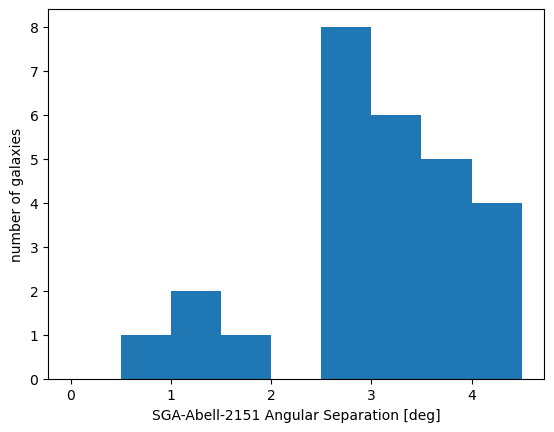

In [16]:
## make a bar graph of the angular separation 
plt.hist(sep_Abell[SGA_in_Abell].to_value('degree'), bins=np.arange(0,5, 0.5))
plt.xlabel('SGA-Abell-2151 Angular Separation [deg]')
plt.ylabel('number of galaxies');

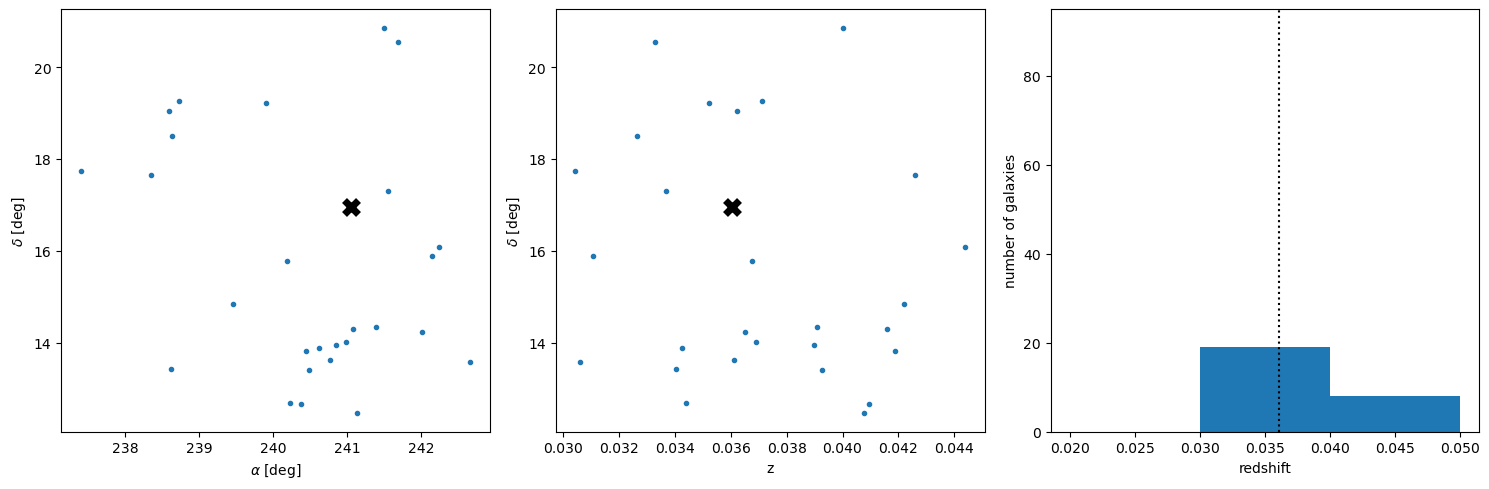

In [17]:
## plot the physical locations and the redshifts of the cluster

plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_in_Abell['TARGET_RA'], centers_in_Abell['TARGET_DEC'], '.')
plt.plot(Abell_coords.transform_to('icrs').ra.deg, Abell_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_in_Abell['Z'], centers_in_Abell['TARGET_DEC'], '.')
plt.plot(v_Abell/c, Abell_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_in_Abell['Z'], bins=np.arange(0.02, .06, 0.01))
plt.vlines(v_Abell/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

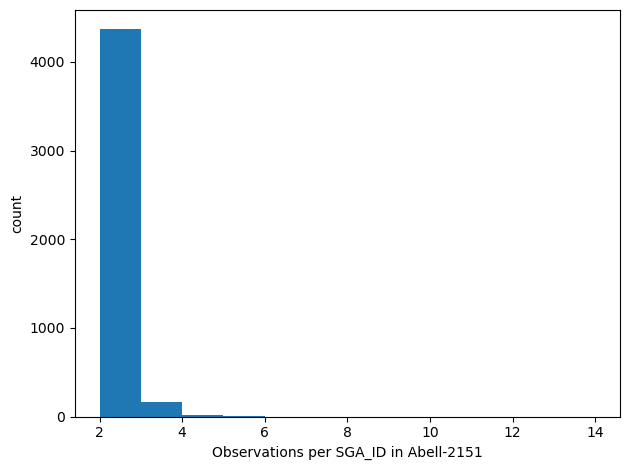

In [18]:
axis_SGAids_Abell, axis_counts_Abell = np.unique(axis_in_Abell['SGA_ID'], return_counts=True)
center_SGAids_Abell, center_counts_Abell = np.unique(centers_in_Abell['SGA_ID'], return_counts=True)

counts_Abell = []

for sga_id in SGA_ID_in_Abell:
    
    center_count_Abell = 0
    axis_count_Abell = 0
    
    if sga_id in center_SGAids_Abell:
        
        center_count_Abell = center_counts_Abell[center_SGAids_Abell == sga_id]
        
    if sga_id in axis_SGAids_Abell:
        
        axis_count_Abell = axis_counts_Abell[axis_SGAids_Abell == sga_id]
        
    count = center_count_Abell + axis_count_Abell
    
    if count > 1:
        
        counts_Abell.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Abell-2151')
plt.ylabel('count');

### Calculate the rotational velocity

In [19]:
axis_in_Abell['SKY_FIBER_DIST'] = 0.
axis_in_Abell['SKY_FIBER_DIST_R26'] = 0.
axis_in_Abell['V_ROT'] = np.nan
axis_in_Abell['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_in_Abell['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_in_Abell['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords_Abell = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords_Abell = SkyCoord(ra=axis_in_Abell['RA'][obs_idx], 
                             dec=axis_in_Abell['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d_Abell = target_coords_Abell.separation(center_coords_Abell)
    
    axis_in_Abell['SKY_FIBER_DIST'][obs_idx] = sep2d_Abell
    axis_in_Abell['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d_Abell.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center_Abell = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2_Abell = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_in_Abell['V_ROT'][obs_idx] = c*(axis_in_Abell['Z'][obs_idx] - z_center_Abell)
    axis_in_Abell['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_in_Abell['ZERR'][obs_idx]**2 + z_err_center2_Abell)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_in_Abell['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

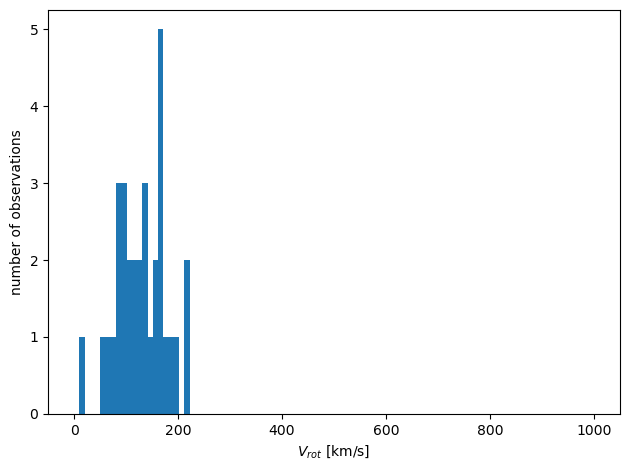

In [20]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_in_Abell['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

### Cut for Abell-2151 galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

#### Velocity Cut

In [21]:
r0p4_Abell = (axis_in_Abell['SKY_FIBER_DIST_R26'] > 0.38) & (axis_in_Abell['SKY_FIBER_DIST_R26'] < 0.42)

Vgood_Abell = (np.abs(axis_in_Abell['V_ROT']) < 1000) & (np.abs(axis_in_Abell['V_ROT']) > 10)

good_axis_in_Abell = axis_in_Abell[r0p4_Abell & Vgood_Abell]

print(len(good_axis_in_Abell), len(np.unique(good_axis_in_Abell['SGA_ID'])))

32 27


#### Relative Velocity Cut

In [22]:
good_deltaV_Abell = np.ones(len(good_axis_in_Abell), dtype=bool)

for sga_id in np.unique(good_axis_in_Abell['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_in_Abell['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin_Abell = np.min(np.abs(good_axis_in_Abell['V_ROT'][obs_idx]))
        Vmax_Abell = np.max(np.abs(good_axis_in_Abell['V_ROT'][obs_idx]))
        
        v_norm_min_Abell = np.abs(good_axis_in_Abell['V_ROT'][obs_idx])/Vmin_Abell
        v_norm_max_Abell = np.abs(good_axis_in_Abell['V_ROT'][obs_idx])/Vmax_Abell
        
        diff_matrix = np.abs(good_axis_in_Abell['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_in_Abell['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin_Abell
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_in_Abell['DELTACHI2'] >= 25
            
            good_deltaV_Abell[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin_Abell = np.min(np.abs(good_axis_in_Abell['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_in_Abell['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_in_Abell['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin_Abell
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_Abell[good_obs_idx] = False

In [23]:
good_deltaV_axis_in_Abell = good_axis_in_Abell[good_deltaV_Abell]

print(len(good_deltaV_axis_in_Abell), len(np.unique(good_deltaV_axis_in_Abell['SGA_ID'])))

32 27


#### Inclination Angle Cut

In [24]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_in_Abell['iSGA'] = -1

for i in range(len(good_deltaV_axis_in_Abell)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_in_Abell['SGA_ID'][i]]
    
    good_deltaV_axis_in_Abell['iSGA'][i] = sga_idx
    
good_deltaV_axis_in_Abell['cosi2'] = SGA['cosi2'][good_deltaV_axis_in_Abell['iSGA']]

In [25]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_in_Abell['cosi2'] <= cosi2_max

good_edge_axis_in_Abell = good_deltaV_axis_in_Abell[edge]

print(len(good_edge_axis_in_Abell), len(np.unique(good_edge_axis_in_Abell['SGA_ID'])))

29 24


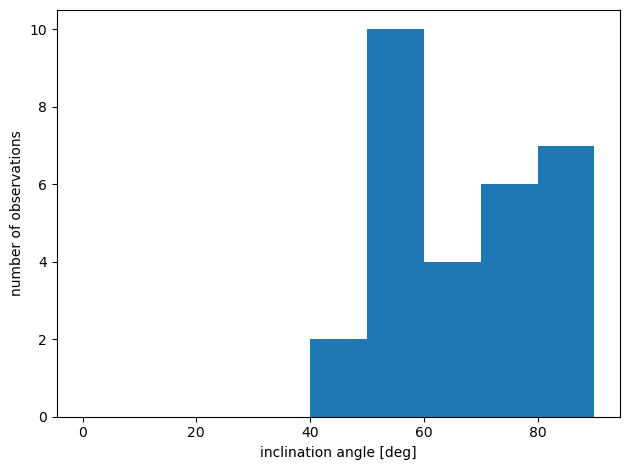

In [26]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_in_Abell['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

#### Morphology Cut

In [27]:
good_edge_axis_in_Abell['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_in_Abell['iSGA']]

In [28]:
spirals_Abell = np.zeros(len(good_edge_axis_in_Abell), dtype=bool)

for i in range(len(good_edge_axis_in_Abell)):
    
    try:    
        if (good_edge_axis_in_Abell['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_in_Abell['MORPHTYPE'][i][:2] != 'S0'):
            spirals_Abell[i] = True
    except IndexError:
        print(good_edge_axis_in_Abell['MORPHTYPE'][i])

good_edge_spirals_axis_in_Abell = good_edge_axis_in_Abell[spirals_Abell]

print(len(good_edge_spirals_axis_in_Abell), len(np.unique(good_edge_spirals_axis_in_Abell['SGA_ID'])))

VI_good_edge_spirals_axis_in_Abell = good_edge_spirals_axis_in_Abell ## delete this line when VI completed

--
24 19


Stopped at visual inspection cut because the number of galaxies dropped below 20.

### Visual Inspection Cut

The visual inspection cut still needs to be done, and there is still a problem with the data above, but we're adding the fitting of the TFR code below so that it should work when the data <i>is</i> correct. At present, the variable `VI_good_edge_spirals_axis_in_Abell = good_edge_spirals_axis_in_Abell`, because the VI hasn't been done yet. Use `VI_good_edge_spirals_axis_in_Abell` to store the results of the visual inspection so the code further down works, and delete the line indicated in the cell above.

Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [29]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights_Abell = 1./(VI_good_edge_spirals_axis_in_Abell['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_in_Abell['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_in_Abell['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_in_Abell['V_ROT'][obs_idx])) ## fiddled with this slightly, check jointlinefit.ipynb for original

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights_Abell[obs_idx]))

In [30]:
# Make a catalog of just those galaxies with velocities
SGA_TF_Abell = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

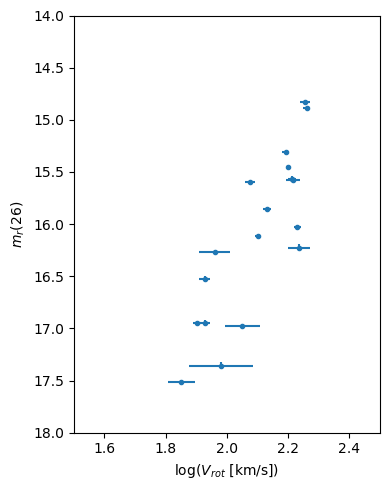

In [31]:
plt.figure(figsize=(4,5), tight_layout=True)

x_Abell = np.log10(SGA_TF_Abell['V_0p33R26'])
y_Abell = SGA_TF_Abell['R_MAG_SB26']

xerr_Abell = SGA_TF_Abell['V_0p33R26_err']/SGA_TF_Abell['V_0p33R26']
yerr_Abell = SGA_TF_Abell['R_MAG_SB26_ERR']

plt.errorbar(x_Abell, y_Abell, 
             yerr_Abell, xerr_Abell, 
             fmt='.')

plt.xlim([1.5, 2.5])
plt.ylim([18, 14])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Virgo Filtering

In [32]:
(c_4r_in_Virgo, SGA_in_Virgo, SGA_ID_in_Virgo, centers_in_Virgo, axis_in_Virgo, Virgo_coords, v_Virgo, sep_Virgo) = cluster_membership(100002)

In [33]:
## Set active row for Virgo nest and base values 
active_row_Virgo = table3_dict[100002]
R2t_Virgo = table3["R2t"][active_row_Virgo]
sigma_Virgo = table3["sigP"][active_row_Virgo]

## Find the coordinates for each cluster
Virgo_coords = SkyCoord(table3["SGLON"][active_row_Virgo]*u.degree, 
                   table3["SGLAT"][active_row_Virgo]*u.degree, 
                   frame='supergalactic')

group_coords = SkyCoord(table2['SGLON']*u.degree, 
                    table2['SGLAT']*u.degree, 
                    frame='supergalactic')

## Match cluster to group coordinates 
idx_Virgo, d2d_Virgo, d3d_Virgo = Virgo_coords.match_to_catalog_sky(group_coords)
v_Virgo = table2["__HV_"][idx_Virgo]

## Match SGA coordinates from unique galaxies to nearest cluster
SGA_coords_Virgo = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')
sep_Virgo = Virgo_coords.separation(SGA_coords_Virgo)

## Convert R2t to an angle 
R2t_Virgo_angle = (R2t_Virgo/(v_Virgo/H0))*u.radian

SGA_in_cluster1_Virgo = (sep_Virgo < 1.5*R2t_Virgo_angle) & (TF_SGA_cp4["Z_DESI"]*c > v_Virgo - 3*sigma_Virgo) & (TF_SGA_cp4["Z_DESI"]*c < v_Virgo + 3*sigma_Virgo)
SGA_in_cluster2_Virgo = (sep_Virgo >= 1.5*R2t_Virgo_angle) & (sep_Virgo < 3*R2t_Virgo_angle) & (TF_SGA_cp4["Z_DESI"]*c > v_Virgo - 2*sigma_Virgo) & (TF_SGA_cp4["Z_DESI"]*c < v_Virgo + 2*sigma_Virgo)

SGA_in_Virgo = SGA_in_cluster1_Virgo | SGA_in_cluster2_Virgo

## Keep observations that are within Virgo-2151
SGA_ID_in_Virgo = TF_SGA_cp4["SGA_ID"][SGA_in_Virgo]

## Gather centers and axes in the cluster
centers_in_Virgo = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Virgo)]
axis_in_Virgo = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_Virgo)]

c_4r_in_Virgo.append(SGA_ID_in_Virgo)

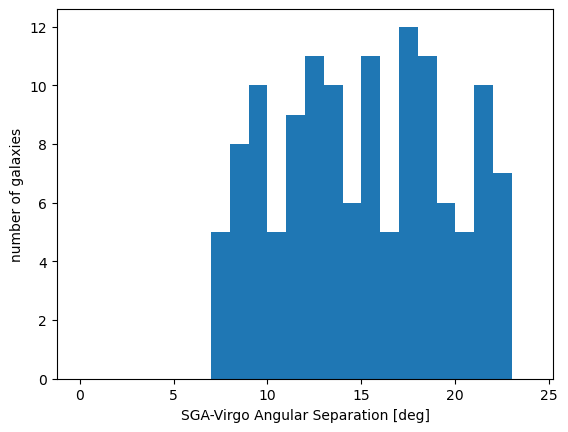

In [34]:
## make a bar graph of the angular separation 
plt.hist(sep_Virgo[SGA_in_Virgo].to_value('degree'), bins=np.arange(0,25, 1))
plt.xlabel('SGA-Virgo Angular Separation [deg]')
plt.ylabel('number of galaxies');

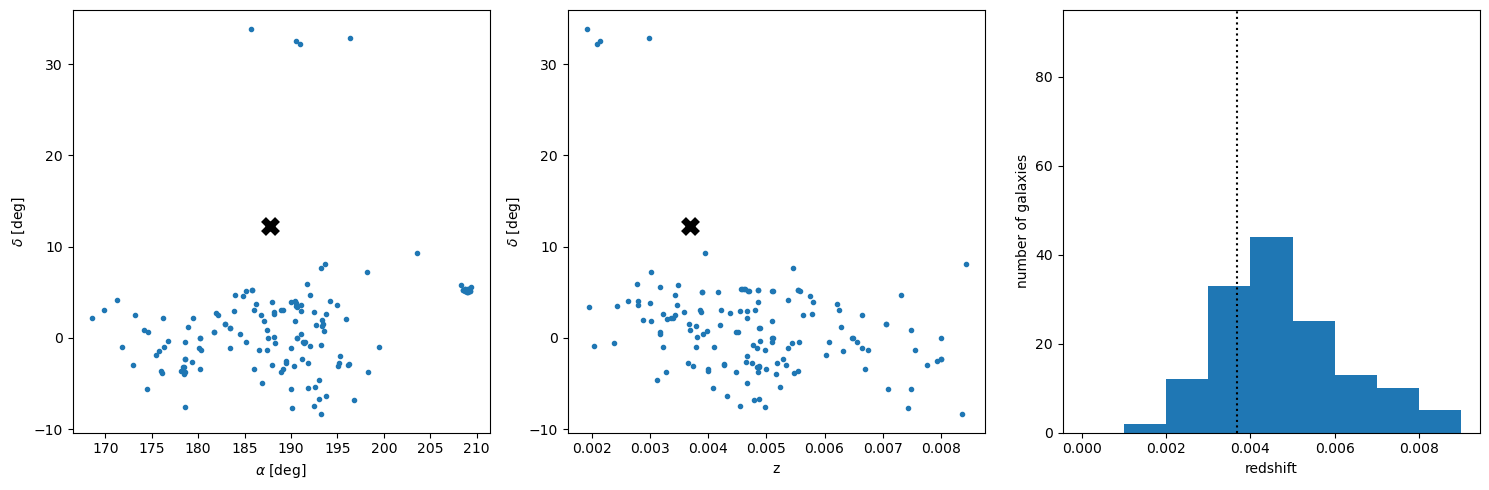

In [35]:
## plot the physical locations and the redshifts of the cluster

plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.plot(centers_in_Virgo['TARGET_RA'], centers_in_Virgo['TARGET_DEC'], '.')
plt.plot(Virgo_coords.transform_to('icrs').ra.deg, Virgo_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
plt.plot(centers_in_Virgo['Z'], centers_in_Virgo['TARGET_DEC'], '.')
plt.plot(v_Virgo/c, Virgo_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
plt.hist(centers_in_Virgo['Z'], bins=np.arange(0, .01, 0.001))
plt.vlines(v_Virgo/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=95);

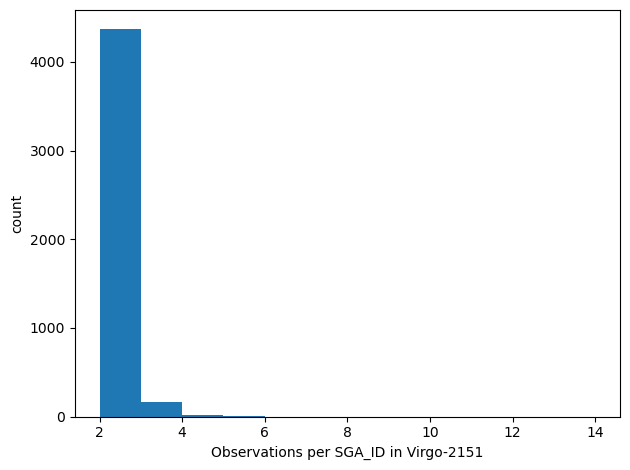

In [36]:
axis_SGAids_Virgo, axis_counts_Virgo = np.unique(axis_in_Virgo['SGA_ID'], return_counts=True)
center_SGAids_Virgo, center_counts_Virgo = np.unique(centers_in_Virgo['SGA_ID'], return_counts=True)

counts_Virgo = []

for sga_id in SGA_ID_in_Virgo:
    
    center_count_Virgo = 0
    axis_count_Virgo = 0
    
    if sga_id in center_SGAids_Virgo:
        
        center_count_Virgo = center_counts_Virgo[center_SGAids_Virgo == sga_id]
        
    if sga_id in axis_SGAids_Virgo:
        
        axis_count_Virgo = axis_counts_Virgo[axis_SGAids_Virgo == sga_id]
        
    count = center_count_Virgo + axis_count_Virgo
    
    if count > 1:
        
        counts_Virgo.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Virgo-2151')
plt.ylabel('count');

### Calculate the rotational velocity

In [37]:
axis_in_Virgo['SKY_FIBER_DIST'] = 0.
axis_in_Virgo['SKY_FIBER_DIST_R26'] = 0.
axis_in_Virgo['V_ROT'] = np.nan
axis_in_Virgo['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_in_Virgo['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_in_Virgo['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords_Virgo = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords_Virgo = SkyCoord(ra=axis_in_Virgo['RA'][obs_idx], 
                             dec=axis_in_Virgo['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d_Virgo = target_coords_Virgo.separation(center_coords_Virgo)
    
    axis_in_Virgo['SKY_FIBER_DIST'][obs_idx] = sep2d_Virgo
    axis_in_Virgo['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d_Virgo.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center_Virgo = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2_Virgo = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_in_Virgo['V_ROT'][obs_idx] = c*(axis_in_Virgo['Z'][obs_idx] - z_center_Virgo)
    axis_in_Virgo['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_in_Virgo['ZERR'][obs_idx]**2 + z_err_center2_Virgo)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_in_Virgo['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

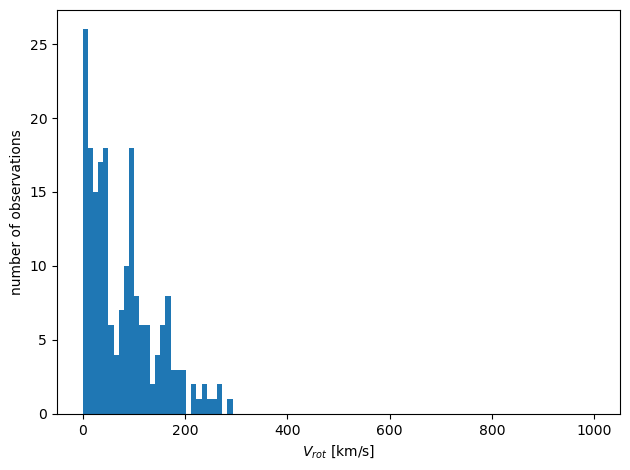

In [38]:
plt.figure(tight_layout=True)

plt.hist(np.abs(axis_in_Virgo['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

### Cut for Virgo galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

#### Velocity Cut

In [39]:
r0p4_Virgo = (axis_in_Virgo['SKY_FIBER_DIST_R26'] > 0.38) & (axis_in_Virgo['SKY_FIBER_DIST_R26'] < 0.42)

Vgood_Virgo = (np.abs(axis_in_Virgo['V_ROT']) < 1000) & (np.abs(axis_in_Virgo['V_ROT']) > 10)

good_axis_in_Virgo = axis_in_Virgo[r0p4_Virgo & Vgood_Virgo]

print(len(good_axis_in_Virgo), len(np.unique(good_axis_in_Virgo['SGA_ID'])))

134 74


#### Relative Velocity Cut

In [40]:
good_deltaV_Virgo = np.ones(len(good_axis_in_Virgo), dtype=bool)

for sga_id in np.unique(good_axis_in_Virgo['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_in_Virgo['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin_Virgo = np.min(np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]))
        Vmax_Virgo = np.max(np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]))
        
        v_norm_min_Virgo = np.abs(good_axis_in_Virgo['V_ROT'][obs_idx])/Vmin_Virgo
        v_norm_max_Virgo = np.abs(good_axis_in_Virgo['V_ROT'][obs_idx])/Vmax_Virgo
        
        diff_matrix = np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_in_Virgo['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin_Virgo
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_in_Virgo['DELTACHI2'] >= 25
            
            good_deltaV_Virgo[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin_Virgo = np.min(np.abs(good_axis_in_Virgo['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_in_Virgo['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_in_Virgo['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin_Virgo
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_Virgo[good_obs_idx] = False

In [41]:
good_deltaV_axis_in_Virgo = good_axis_in_Virgo[good_deltaV_Virgo]

print(len(good_deltaV_axis_in_Virgo), len(np.unique(good_deltaV_axis_in_Virgo['SGA_ID'])))

134 74


#### Inclination Angle Cut

In [42]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

good_deltaV_axis_in_Virgo['iSGA'] = -1

for i in range(len(good_deltaV_axis_in_Virgo)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_in_Virgo['SGA_ID'][i]]
    
    good_deltaV_axis_in_Virgo['iSGA'][i] = sga_idx
    
good_deltaV_axis_in_Virgo['cosi2'] = SGA['cosi2'][good_deltaV_axis_in_Virgo['iSGA']]

In [43]:
i_min = 45. # degrees

cosi2_max = np.cos(i_min*np.pi/180.)**2

edge = good_deltaV_axis_in_Virgo['cosi2'] <= cosi2_max

good_edge_axis_in_Virgo = good_deltaV_axis_in_Virgo[edge]

print(len(good_edge_axis_in_Virgo), len(np.unique(good_edge_axis_in_Virgo['SGA_ID'])))

113 62


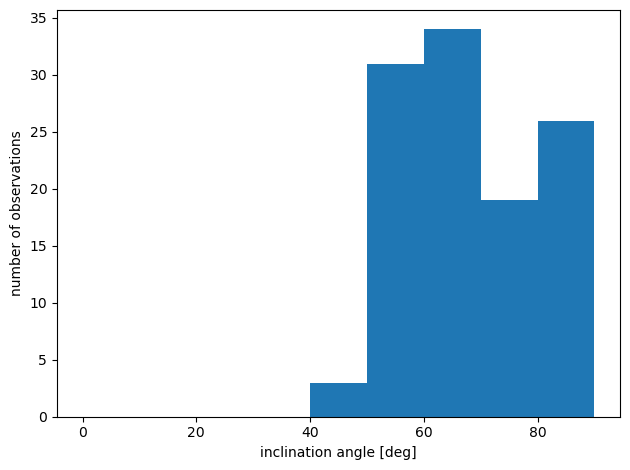

In [44]:
plt.figure(tight_layout=True)

plt.hist(np.arccos(np.sqrt(good_edge_axis_in_Virgo['cosi2']))*180/np.pi, bins=np.linspace(0, 90, 10))

plt.xlabel('inclination angle [deg]')
plt.ylabel('number of observations');

#### Morphology Cut

In [45]:
good_edge_axis_in_Virgo['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_in_Virgo['iSGA']]

In [46]:
spirals_Virgo = np.zeros(len(good_edge_axis_in_Virgo), dtype=bool)

for i in range(len(good_edge_axis_in_Virgo)):
    
    try:    
        if (good_edge_axis_in_Virgo['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_in_Virgo['MORPHTYPE'][i][:2] != 'S0'):
            spirals_Virgo[i] = True
    except IndexError:
        print(good_edge_axis_in_Virgo['MORPHTYPE'][i])

good_edge_spirals_axis_in_Virgo = good_edge_axis_in_Virgo[spirals_Virgo]

print(len(good_edge_spirals_axis_in_Virgo), len(np.unique(good_edge_spirals_axis_in_Virgo['SGA_ID'])))

VI_good_edge_spirals_axis_in_Virgo = good_edge_spirals_axis_in_Virgo ## delete this line when VI is completed

--
--
--
--
--
61 26


### Visual Inspection Cut

The visual inspection cut still needs to be done, and there is still a problem with the data above, but we're adding the fitting of the TFR code below so that it should work when the data <i>is</i> correct. At present, the variable `VI_good_edge_spirals_axis_in_Virgo = good_edge_spirals_axis_in_Virgo`, because the VI hasn't been done yet. Use `VI_good_edge_spirals_axis_in_Virgo` to store the results of the visual inspection so the code further down works, and delete the line indicated in the cell above.

In [47]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/iron_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [48]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_err'] = np.nan

weights_Virgo = 1./(VI_good_edge_spirals_axis_in_Virgo['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_in_Virgo['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_in_Virgo['SGA_ID'] == sga_id
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_in_Virgo['V_ROT'][obs_idx])) ## fiddled with this slightly, check jointlinefit.ipynb for original

    SGA['V_0p33R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights_Virgo[obs_idx]))

In [49]:
# Make a catalog of just those galaxies with velocities
SGA_TF_Virgo = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

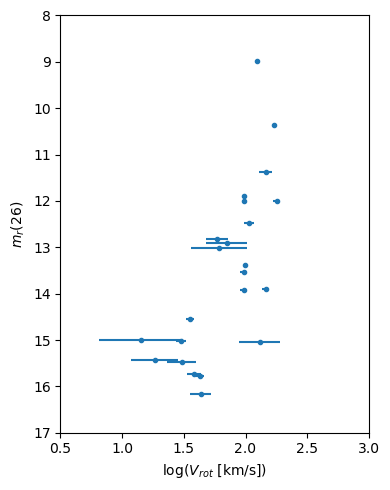

In [50]:
plt.figure(figsize=(4,5), tight_layout=True)

x_Virgo = np.log10(SGA_TF_Virgo['V_0p33R26'])
y_Virgo = SGA_TF_Virgo['R_MAG_SB26']
xerr_Virgo = SGA_TF_Virgo['V_0p33R26_err']/SGA_TF_Virgo['V_0p33R26'],
yerr_Virgo = SGA_TF_Virgo['R_MAG_SB26_ERR']

plt.errorbar(x_Virgo, y_Virgo,
             yerr_Virgo, xerr_Virgo,
             fmt='.')

plt.xlim([0.5, 3])
plt.ylim([17, 8])

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

## Fitting the TFR

In [51]:
# Pull the first data set from the Abell-2151 filtering above, and pack the results into the arrays data1 and cov1.
data_Abell = [] 
data_Abell.append(x_Abell)
data_Abell.append(y_Abell)
dx_Abell, dy_Abell = xerr_Abell, yerr_Abell

data1 = data_Abell

cov1 = np.empty((2, 2, len(x_Abell)))
for i, (dx, dy) in enumerate(zip(dx_Abell, dy_Abell)):
    cov1[:, :, i] = np.array([[dx**2, dx*dy], [dx*dy, dy**2]])

# Pull the second data set from the Virgo filtering, and pack the results into the arrays data2 and cov2.

data_Virgo = [] 
data_Virgo.append(x_Virgo)
data_Virgo.append(y_Virgo)
dx_Virgo, dy_Virgo = xerr_Virgo, yerr_Virgo

data2 = data_Virgo

cov2 = np.empty((2, 2, len(x_Virgo))) ## note that this cov2 is WRONG right now, it's for Virgo but with Abell numbers because Virgo's are weird
for i, (dx, dy) in enumerate(zip(dx_Virgo, dy_Virgo)):
    cov2[:, :, i] = np.array([[dx**2, dx*dy], [dx*dy, dy**2]])

/tmp/ipykernel_1818625/324807472.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cov2[:, :, i] = np.array([[dx**2, dx*dy], [dx*dy, dy**2]])


ValueError: setting an array element with a sequence.

(18.0, 8.0)

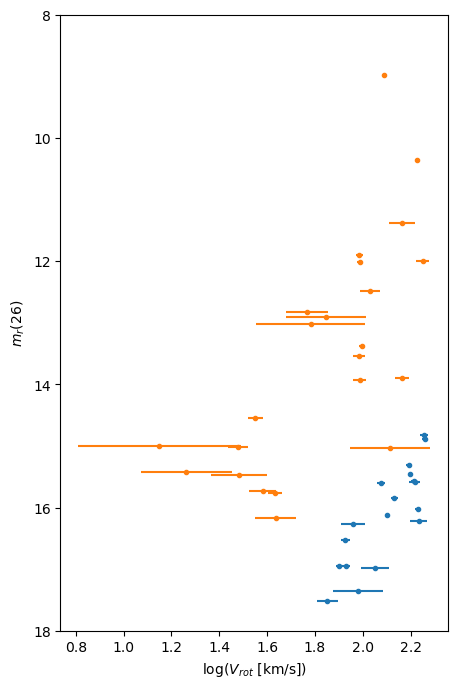

In [52]:
## Plot of the correct data, but not using covariance calculations above (this cell should be deleted eventually) 

fig, ax = plt.subplots(1,1, figsize=(5,8))
eb1 = ax.errorbar(x_Abell, y_Abell, yerr_Abell, xerr_Abell, fmt='.')
eb2 = ax.errorbar(x_Virgo, y_Virgo, yerr_Virgo, xerr_Virgo, fmt='.')
ax.set(xlabel='log($V_{rot}$ [km/s])', ylabel='$m_r (26)$');
ax.set_ylim(18,8)

(18.0, 8.0)

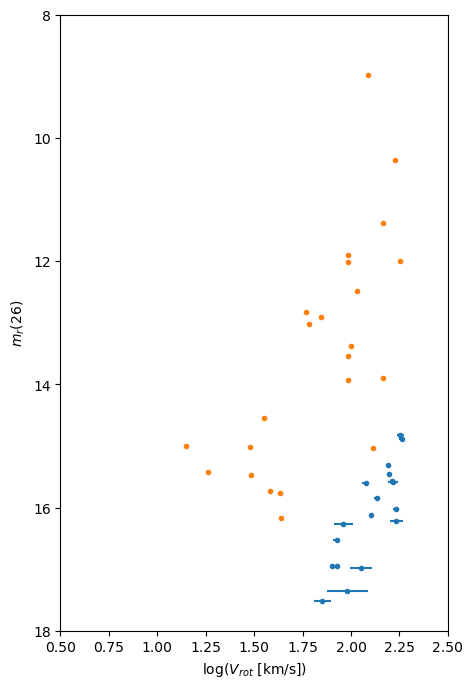

In [53]:
## Eventually correct plotting, but it's doing the weird covariance from two cells up so this is WRONG (this cell is what should be used once cov2 is handled)
fig, ax = plt.subplots(1,1, figsize=(5,8))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')

ax.set(xlabel='log($V_{rot}$ [km/s])', ylabel='$m_r (26)$');
ax.set_xlim(0.5,2.5)
ax.set_ylim(18,8)

### Standard Fit

Attempt a standard $\chi^2$ fit to the data. Use both the uncertainties in $x$ and $y$, but ignore the covariances. Here we use the form of the $\chi^2$ defined in **Numerical Recipes in C++**, eq. 15.3.2:

$$
\chi^2(a,b) = \sum_{i}\frac{(y_i-ax_i-b)^2}{\sigma_{y_i}^2 + a^2\sigma_{x_i}^2}
$$

In this case, we divide the data in two and specify the parameters as the array `[a, b1, b2]`.

In [54]:
def chi2(params, data1, data2, cov1, cov2):    
    """Chi-square function for joint slope fit to two data sets.
    
    Parameters
    ----------
    data1 : ndarray
        2xN array of [x1, y1] for data set 1.
    data2 : ndarray
        2xM array of [x2, y2] for data set 2.
    cov1 : ndarray
        2x2xN covariances for data set 1.
    cov2 : ndarray
        2x2xM covariances for data set 2.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    a, b1, b2 = params
    
    x1, y1 = data1[0], data1[1]
    varx1, vary1 = cov1[0,0], cov1[1,1]
    chi2_1 = np.sum((y1 - a*x1 - b1)**2 / (vary1 + a**2*varx1))
    
    x2, y2 = data2[0], data2[1]
    ##varx2, vary2 = cov2[0,0], cov2[1,1]
    varx2, vary2 = (xerr_Virgo[0])**2, (yerr_Virgo[0])**2 ## makeshift cov2 
    chi2_2 = np.sum((y2 - a*x2 - b2)**2 / (vary2 + a**2*varx2))
    
    return chi2_1 + chi2_2

### Peform the Fit and Plot Results

Use the `BFGS` minimizer to find the best fit parameters.

Note that the result may depend sensitively on the initial seed values.

In [55]:
p0 = [1.5, 0.7, 1.2]
res = minimize(chi2, p0, args=(data1, data2, cov1, cov2), method='BFGS')
res

      fun: 2782.3294988571315
 hess_inv: array([[ 28.86906086, -42.85252429, -28.86892051],
       [-42.85252428,  63.60928648,  42.85244   ],
       [-28.86892051,  42.85244   ,  28.86897996]])
      jac: array([-0.11865234, -0.13757324,  0.08557129])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 376
      nit: 51
     njev: 91
   status: 2
  success: False
        x: array([ 17678.29228387, -38141.40655189, -36865.16542547])

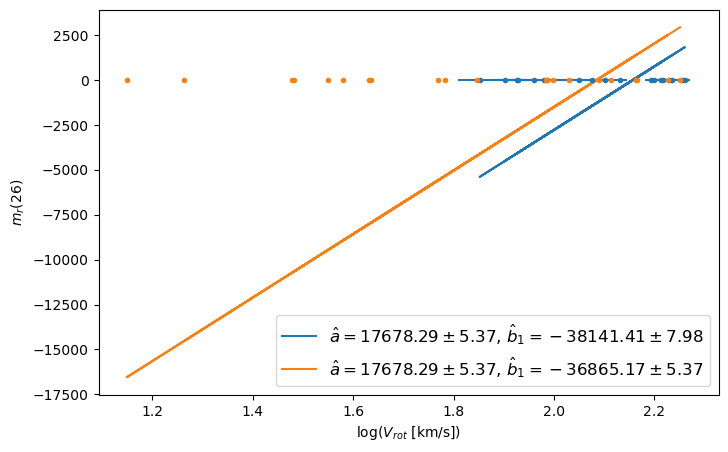

In [56]:
## Something is definitely wrong here. definitely cov2. 

a_, b1_, b2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
ax.plot(data1[0], a_*data1[0] + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))

ax.set(xlabel='log($V_{rot}$ [km/s])', ylabel='$m_r (26)$')
ax.legend(fontsize=12);

### Enable a Joint Fit in `hyperfit`

Here we set up a new class that can handle multiple data sets at once. The main condition is that the linear fits to the data always have a common slope.

In [57]:
def nlogl(params, datasets, covs):
    """Chi-square function for joint slope fit to two or more data sets.
    
    Parameters
    ----------
    datasets : list or ndarray
        m x 2xN array of [x1, y1] for each data set.
    cov : ndarray
        m x 2x2xN covariances for each data set.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    nsets = len(datasets)
    a = params[0]
    b = params[1:nsets+1]
    sigma = params[nsets+1:]
    
    nloglike = 0.
    for i in range(nsets): 
        data = datasets[i]
        cov = covs[i]
        x, dx2 = data[0], cov[0,0]
        y, dy2 = data[1], cov[1,1]
        dxy = cov[0,1]
        sy2 = sigma[i]**2 + a**2*dx2 + dy2 - 2*dxy*a
        nloglike += -0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b[i])**2/sy2)
    
    return nloglike

# Minimization.
print('Differential evolution:')
bounds = [[-10., 10.], [-6., 6.], [-5., 5.], [0, 1], [0, 2]]
res = differential_evolution(nlogl, bounds, args=([data1, data2], [cov1, cov2]))
print(res)

# Initial guesses
slope = 1.5
intercepts = [0.7, 1.3]
sigmas = [0.2, 0.3]
p0 = [slope] + intercepts + sigmas

print('\n\nBFGS minimization:')
res = minimize(nlogl, p0, args=([data1, data2], [cov1, cov2]), method='BFGS')
print(res)

Differential evolution:
     fun: -6.226318471066837
     jac: array([-1.91846540e-05, -5.50670624e-06, -5.24025271e-06, -1.53362065e+01,
       -1.58845650e+01])
 message: 'Optimization terminated successfully.'
    nfev: 4803
     nit: 62
 success: True
       x: array([4.99342899, 5.61897203, 4.36137328, 1.        , 2.        ])


BFGS minimization:
      fun: -36.9688185502077
 hess_inv: array([[ 2.10582181e+09, -4.87383515e+09, -2.78460723e+09,
         3.15047625e+08,  3.63737792e+08],
       [-4.87383516e+09,  1.12802845e+10,  6.44485518e+09,
        -7.29164350e+08, -8.41855673e+08],
       [-2.78460723e+09,  6.44485518e+09,  3.68219067e+09,
        -4.16599301e+08, -4.80984136e+08],
       [ 3.15047625e+08, -7.29164350e+08, -4.16599301e+08,
         4.71336205e+07,  5.44180552e+07],
       [ 3.63737793e+08, -8.41855676e+08, -4.80984138e+08,
         5.44180554e+07,  6.28282892e+07]])
      jac: array([ 0.00189304,  0.00010014,  0.00048923, -0.00411606, -0.00194502])
  message:

(18.0, 8.0)

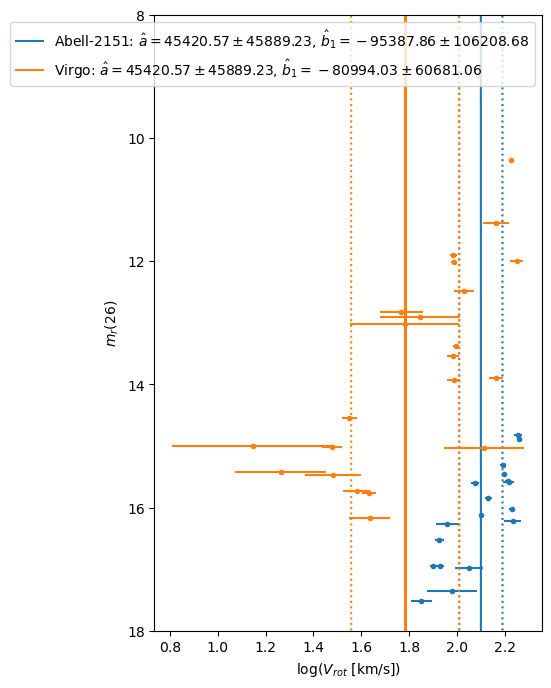

In [58]:
a_, b1_, b2_, sig1_, sig2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(5,8))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
x_ = np.linspace(np.min(data1[0]), np.max(data1[0]))
ax.plot(x_, a_*x_ + b1_, color=eb1[0].get_color(),
        label=r'Abell-2151: $\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))
ax.plot(x_, a_*x_ + b1_ + sig1_, ls=':', color=eb1[0].get_color())
ax.plot(x_, a_*x_ + b1_ - sig1_, ls=':', color=eb1[0].get_color())

##eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
eb2 = ax.errorbar(data2[0], data2[1], yerr_Virgo, xerr_Virgo, fmt='.')

x_ = np.linspace(np.min(data2[0]), np.max(data2[0]))
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'Virgo: $\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))
ax.plot(x_, a_*x_ + b2_ + sig2_, ls=':', color=eb2[0].get_color())
ax.plot(x_, a_*x_ + b2_ - sig2_, ls=':', color=eb2[0].get_color())

ax.set(xlabel='log($V_{rot}$ [km/s])', ylabel='$m_r (26)$')
ax.legend()
ax.set_ylim(18,8)

## Encapsulate Multi-Dataset Fits in a Single Class

Define a class `MultiLinFit` that takes in a list of datasets and covariances, each in the same format used by `LinFit` in the hyperfit package. I.e.,
* `data` are 2xN arrays, and `datasets` is a list of `data`.
* `cov` are 2x2xN arrays, and `covs` is a list of `cov`.

Note that the data sets can be different sizes.

While the `LinFit` class allows for higher-dimensional fits -- planes and hyperplanes in addition to lines -- this class only fits lines, as needed for the Tully-Fisher relation. It is assumed that all data sets share a common slope but have different intercepts and scatter parameters. The fit parameters are of the form

$$
\vec{\theta} = (a, b_1, b_2, \ldots, b_m, \sigma_1, \sigma_2, \ldots, \sigma_m),
$$

where $a$ is the common slope, $b_1,\ldots,b_m$ are the intercepts for the $m$ datasets, and $\sigma_1,\ldots,\sigma_m$ are the scatter parameters for each dataset.

In [59]:
class MultiLinFit:
    """Class to implement linear fits to multiple datasets, assuming
    a common slope but different intercepts across each set.
    
    Based on the hyperfit algorithm of Robotham and Obreschkow (PASP 2015)
    and the Python LinFit implementation of Howlett and Gordon
    (https://hyperfit.readthedocs.io/en/latest/).
    
    Attributes
    ----------
    nsets : int
        Number of data sets and covariances entered by user.
    ndims : int
        Dimensionality of the data (expect 2).
    ndata : ndarray
        Array giving the length of every input data vector.
    params : ndarray
        Best-fit linear parameters for the data sets.
    params_scatter : ndarray
        Best-fit scatters along the y-axis for each data set.
    
    Parameters
    ----------
    datasets : list or ndarray
        An Mx2xN array of 2xN data vectors.
    covs : list or ndarray
        An Mx2x2xN array of 2x2xN covariance matrices.
    weights : ndarray
        Array of weights for each data set. Unit weights if not specified.
    vertaxis : float
        Specify which coordinate axis in data is the 'vertical' one. Defaults to last axis (-1).
    """
    
    def __init__(self, datasets, covs, weights=None, vertaxis=-1):
        
        self.nsets = len(datasets)
        self.ndims = np.shape(datasets[0])[0]
        self.ndata = np.array([np.shape(data)[1] for data in datasets])
        self.datasets = datasets
        self.covs = covs
        self.data = None
        self.cov = None
        
        self.npars = 1 + self.nsets # slope + intercepts + sigmas
        self.params = np.zeros(self.npars)
        self.params_scatter = np.zeros(self.nsets)
        
        self.weights = [np.ones(n) for n in self.ndata] if weights is None else weights
        self.vertaxis = vertaxis
        
        self.param_bounds = None      # parameter fit bounds for all data sets
        
    # Log posterior function.
    def _lnpost(self, params):
        lnpost = 0.

        for i in range(self.nsets):
            # Loop over individual data sets. 
            self.data = self.datasets[i]
            self.cov  = self.covs[i]
            
            # Set up parameter and bounds arrays for each data set.
            pars_i = np.array([params[0]] + [params[1+i]] + [params[self.nsets+1+i]])
            bounds_i = [self.param_bounds[0]] + \
                       [self.param_bounds[1+i]] + \
                       [self.param_bounds[self.nsets+1+i]]

            # Set up weights for each data set.
            weights = self.weights[i]
            
            # Sum over all data sets.
            lnprior = self._lnprior(pars_i, bounds_i)
            lnlike = self._lnlike(pars_i)                
            lnpost += np.sum(weights * lnlike) + lnprior
        
        return lnpost
            
    # Log prior function.
    def _lnprior(self, params, bounds):
        lnprior = 0.
        for i, (param, bound) in enumerate(zip(params.T, bounds)):
            lnprior += np.where(np.logical_or(param < bound[0], param > bound[1]), -np.inf, 0.0)

        return lnprior
    
    # Log likelihood function.
    def _lnlike(self, params):
        a, b, sigma = params

        x, dx2 = self.data[0], self.cov[0,0]
        y, dy2 = self.data[1], self.cov[1,1]
        dxy = self.cov[0,1]
        sy2 = sigma**2 + a**2*dx2 + dy2 - 2*dxy*a
        lnlike = 0.5*np.sum(np.log((a**2 + 1)/sy2) - (a*x - y + b)**2/sy2)

        return lnlike
    
    def bessel_cochran(self, sigma):
        """Bessel-Cochran correction of sample scatter to population scatter.
        
        Parameters
        ----------
        sigma : ndarray
            1xM array of scatters for the M input datasets.
        
        Returns
        -------
        sigma_corr : ndarray
            1xM array of corrected scatter parameters.
        """
        sigma_corr = (
            np.sqrt(0.5 * self.ndata)
            * np.exp(loggamma(0.5 * (self.ndata - self.ndims)) - loggamma(0.5 * (self.ndata - self.ndims + 1.0)))
        ) * sigma

        return sigma_corr
    
    def optimize(self, bounds, tol=1e-6, verbose=False):
        """Find the best-fit line for multiple datasets, assuming a
        common slope across all sets but independent intercepts and scatters.
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        tol : float
            Optimization tolerance.
        verbose : bool
            Print fit result.
            
        Returns
        -------
        params : ndarray
            Array of best-fit slope and intercepts [a, b1, b2, ..., bm]
        params_scatter : ndarray
            Array of vertical axis scatter parameters [sig1, sig2, ... sigm]
        log_posterior : float
            Value of ln(posterior) at the best fit point.
        """
        self.param_bounds = bounds
        res = differential_evolution(lambda *args: -self._lnpost(*args), self.param_bounds, tol=tol)

        if verbose:
            print(res)
            
        self.params = res.x[:-self.nsets]
        self.params_scatter = np.fabs(res.x[-self.nsets:])
        self.params_scatter = self.bessel_cochran(self.params_scatter)
        return self.params, self.params_scatter, -res.fun
    
    def emcee(self, bounds, max_iter=100000, batchsize=1000, ntau=50.0, tautol=0.05, verbose=False):
        """Run MCMC using the emcee EnsembleSampler.
        
        The MCMC is seeded using a randomization of the best-fit values of the
        common slope, intercepts, and vertical scatters [a, b1, ..., bm, sig1, ..., sigm].
        
        Parameters
        ----------
        bounds : sequence
            Bounds for variables [a, b1, ..., bm, sig1, ..., sigm].
        max_iter : int
            Maximum number of MCMC iterations.
        batchsize : int
            Size of each batch. Convergence checked after each batch.
        ntau : float
            Minimum autocorrelation length to consider for convergence.
        tautol : float
            Maximum fractional deviation between successive autocorrelation lengths for convergence.
        verbose : bool
            Print out convergence statistics and progress bars if True.
            
        Returns
        -------
        mcmc_samples : ndarray
            Array of flattened and burned-in MCMC samples.
        mcmc_lnlike : ndarray
            Log-likelihood values of every MCMC sample.
        """

        # Set up emcee. Start the walkers in a small 1 percent ball around the best fit.
        # The best fit will set self.params and self.params_scatter.
        self.optimize(bounds, verbose=verbose)
        ndim = len(self.params) + len(self.params_scatter)
        nwalker = 4 * ndim
        seeds = np.asarray([
            [(0.01 * np.random.rand() + 0.995) * j for j in np.concatenate([self.params, self.params_scatter])]
            for _ in range(nwalker)
        ])

        sampler = emcee.EnsembleSampler(nwalker, ndim, self._lnpost)

        old_tau = np.inf
        niter = 0
        converged = 0
        while ~converged:
            sampler.run_mcmc(seeds, nsteps=batchsize, progress=verbose)
            tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
            converged = np.all(ntau * tau < niter)
            converged &= np.all(np.abs(old_tau - tau) / tau < tautol)
            old_tau = tau
            begin = None
            niter += 1000
            if verbose:
                print("Niterations/Max Iterations: ", niter, "/", max_iter)
                print("Integrated ACT/Min Convergence Iterations: ", tau, "/", np.amax(ntau * tau))
            if niter >= max_iter:
                break

        # Remove burn-in and and save the samples
        tau = sampler.get_autocorr_time(discard=int(0.5 * niter), tol=0)
        burnin = int(2 * np.max(tau))
        samples = sampler.get_chain(discard=burnin, flat=True).T
        mcmc_samples = samples
        mcmc_lnlike = sampler.get_log_prob(discard=burnin, flat=True)

        return mcmc_samples, mcmc_lnlike

In [60]:
mlf = MultiLinFit([data1, data2], [cov1, cov2])

In [61]:
mlf.params_scatter, mlf.ndata, mlf.ndims

(array([0., 0.]), array([18, 23]), 2)

In [62]:
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.], [0., 2.]]
mlf.optimize(bounds, verbose=True)

     fun: -129.2131418491478
     jac: array([ 2.31921150e-03, -3.87672119e-03,  2.28794762e-03, -1.56887837e-03,
       -4.34469143e+02])
 message: 'Optimization terminated successfully.'
    nfev: 9036
     nit: 119
 success: True
       x: array([5.59004401, 4.37977461, 3.26807447, 1.45448893, 2.        ])


(array([5.59004401, 4.37977461, 3.26807447]),
 array([1.56699689, 2.11812941]),
 129.2131418491478)

In [63]:
# Run an MCMC
bounds = [[-10., 10.], [-10., 10.], [-10., 10.], [0., 2.], [0., 2.]]
mcmc_samples, mcmc_lnlike = mlf.emcee(bounds, max_iter=10000, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

100%|██████████| 1000/1000 [00:06<00:00, 144.15it/s]


Niterations/Max Iterations:  4000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


100%|██████████| 1000/1000 [00:06<00:00, 144.65it/s]


Niterations/Max Iterations:  5000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


100%|██████████| 1000/1000 [00:06<00:00, 145.46it/s]


Niterations/Max Iterations:  6000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


100%|██████████| 1000/1000 [00:06<00:00, 145.68it/s]


Niterations/Max Iterations:  7000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


100%|██████████| 1000/1000 [00:07<00:00, 136.13it/s]


Niterations/Max Iterations:  8000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


100%|██████████| 1000/1000 [00:06<00:00, 144.96it/s]


Niterations/Max Iterations:  9000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


100%|██████████| 1000/1000 [00:06<00:00, 146.03it/s]


Niterations/Max Iterations:  10000 / 10000
Integrated ACT/Min Convergence Iterations:  [nan nan nan nan nan] / nan


ValueError: cannot convert float NaN to integer

In [64]:
fig = corner(mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=['$a$', '$b_1$', '$b_2$', r'$\sigma_1$', r'$\sigma_2$'],
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 12})

fig.savefig('multiline_fit_corner.png', dpi=100)

NameError: name 'mcmc_samples' is not defined